# Diagnostic Action Sequence Prediction (DAS) Model

This model uses past sequences of diagnostic actions to predict the most likely sequence of future actions. It does not consider the fault or claim history of a vehicle.

In [1]:
import numpy as np
import pandas as pd
import keras_nlp
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from sklearn.model_selection import train_test_split
from keras.layers import TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import plot_model, pad_sequences
from datetime import datetime

2023-08-04 18:55:06.907244: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load prepared data
df = pd.read_csv('./data_out/prepared_data_half.csv', low_memory=False)

In [3]:
# Sort values by 'consultationid' to ensure actions for the same consultation are together
df.sort_values(['consultationid', 'timestamp'], inplace=True)
df['otxsequence'] = df['otxsequence'].astype(str)

# Group by consultationid and join the activities
grouped = df.groupby('consultationid')['otxsequence'].apply(list).reset_index()

# Drop duplicates
grouped = grouped.drop_duplicates('consultationid')
grouped

,consultationid,otxsequence
0,80,[72]
1,95,[1]
2,1196,"[72, 72, 72]"
3,2569,"[89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 8..."
4,2823,"[72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 7..."
...,...,...
1985,646416,"[56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]"
1986,656555,"[72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 7..."
1987,658364,"[72, 72, 72, 72, 72, 72, 72, 72, 72]"
1988,660582,"[72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 7..."


In [4]:
sequences = grouped['otxsequence'].apply(lambda x: list(map(int, x)))

# Compute the average length of the unique actions in each sequence,
# this is the number of actions the model will be predicting
seq_length = int(np.mean([len(set(seq)) for seq in sequences]))

# prepare the sequences
X, y = [], []
for seq in sequences:
    for i in range(seq_length, len(seq)):
        X.append(seq[i-seq_length:i])
        y.append(seq[i:i+seq_length])

# Pad sequences to ensure consistent length
X = pad_sequences(X, maxlen=seq_length, padding='post')
y = pad_sequences(y, maxlen=seq_length, padding='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
num_activities = df['otxsequence'].nunique()

model = Sequential()
model.add(Embedding(input_dim=num_activities+1, output_dim=64, input_length=seq_length))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(TimeDistributed(Dense(num_activities+1, activation='softmax')))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy',
                                                                                 keras_nlp.metrics.Perplexity,
                                                                                 keras_nlp.metrics.EditDistance])

model.summary()
plot_model(model, to_file='fixtures/models/das_layers.png', show_shapes=True, show_layer_names=True)

2023-08-04 21:27:11.736759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 21:27:11.742191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 21:27:11.748387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

NameError: name 'keras_nlp' is not defined

In [6]:
%%time
early_stopping_monitor = EarlyStopping(
    monitor='accuracy',
    min_delta=0.001,  # minimum change to qualify as an improvement
    patience=5,  # number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    np.expand_dims(y_train, -1),
    epochs=50,
    validation_data=(X_test, np.expand_dims(y_test, -1)),
    callbacks=[early_stopping_monitor])

Epoch 1/50


2023-08-04 18:55:21.205959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 18:55:21.209021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 18:55:21.210867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1055/1059 [============================>.] - ETA: 0s - loss: 0.6272 - accuracy: 0.8794

2023-08-04 18:55:29.776056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 18:55:29.778156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 18:55:29.779981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1059/1059 [==============================] - 10s 6ms/step - loss: 0.6255 - accuracy: 0.8798 - val_loss: 0.0874 - val_accuracy: 0.9867
Epoch 2/50
1059/1059 [==============================] - 5s 5ms/step - loss: 0.0675 - accuracy: 0.9901 - val_loss: 0.0548 - val_accuracy: 0.9928
Epoch 3/50
1059/1059 [==============================] - 5s 5ms/step - loss: 0.0486 - accuracy: 0.9932 - val_loss: 0.0454 - val_accuracy: 0.9937
Epoch 4/50
1059/1059 [==============================] - 5s 5ms/step - loss: 0.0417 - accuracy: 0.9941 - val_loss: 0.0440 - val_accuracy: 0.9943
Epoch 5/50
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0391 - accuracy: 0.9944 - val_loss: 0.0427 - val_accuracy: 0.9949
Epoch 6/50
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0380 - accuracy: 0.9946 - val_loss: 0.0404 - val_accuracy: 0.9949
Epoch 7/50
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0374 - accuracy: 0.9946 - val_loss: 0.0402 - val_accuracy: 0.9950
Ep

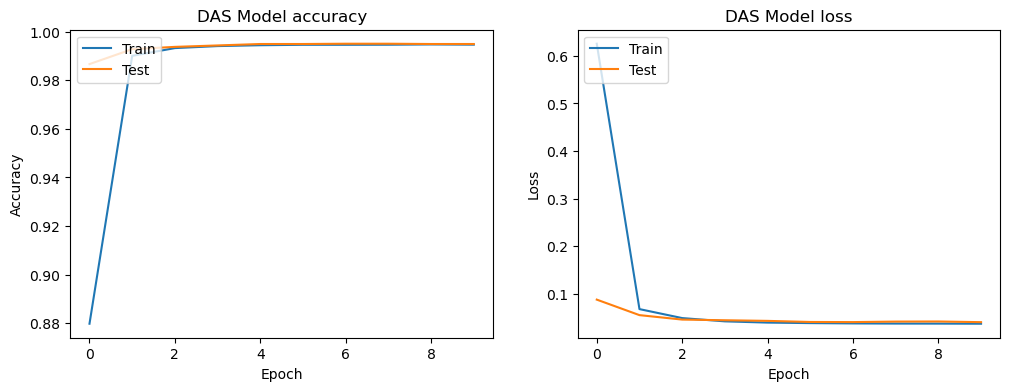

In [7]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('DAS Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DAS Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.savefig('fixtures/models/das_training.png')


In [9]:
from data_preprocessing import save_csv

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, np.expand_dims(y_test, -1))
save_csv(pd.DataFrame(y_test), 'models_test/da_y_test.csv')
save_csv(pd.DataFrame(X_test), 'models_test/da_X_test_input.csv')
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

265/265 [==============================] - 1s 3ms/step - loss: 0.0427 - accuracy: 0.9949
Test Loss: 0.04270774498581886
Test Accuracy: 0.9949226379394531


This will save the architecture of the model, the weights of the model, the training configuration (loss, optimizer), and the state of the optimizer, allowing us to resume training exactly where we left off.

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model.save(f'fixtures/models/das_{timestamp}.h5')